<a href="https://colab.research.google.com/github/kshs040666/MyMaster/blob/main/FasterRCNN/Alexnet_FRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd drive/MyDrive/Colab Notebooks/20220819
!pip install -r requirements.txt

In [ ]:
import pandas as pd
import seaborn as sn
import numpy as np
import cv2
import os
import re
import time
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import layoutparser as lp
from pycocotools.coco import COCO

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.get_device_name())

Tesla P100-PCIE-16GB


In [ ]:
# %cd wood_defect_dataset_COCO_format
root = 'wood_defect_dataset_COCO_format'
train_anns_path = os.path.join(root, 'annotations', 'instances_train2017.json')
val_anns_path = os.path.join(root, 'annotations', 'instances_val2017.json')
test_anns_path = os.path.join(root, 'annotations', 'instances_test2017.json')
train_coco = COCO(train_anns_path)
val_coco = COCO(val_anns_path)
test_coco = COCO(test_anns_path)

loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
class WoodDataset(Dataset):
    def __init__(self, image_dir, coco, transforms=None, mode='train'):
        super().__init__()
        self.image_dir = image_dir
        self.coco = coco        
        self.transforms = transforms
        
        
    def __getitem__(self, index : int):
        index += 1
        image_id = index
        image_info = self.coco.imgs[index]
        anns = self.coco.loadAnns(self.coco.getAnnIds([index]))
        n = len(anns)

        image = cv2.imread(os.path.join(self.image_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        boxes=np.zeros((n, 4))
        area = np.zeros(n)
        iscrowd = np.zeros(n)
        labels = np.zeros(n, dtype = np.int64)
        image_ids = np.zeros(n)

        for i in range(n):
          boxes[i, :] = anns[i]['bbox']
          area[i] = anns[i]['area']
          iscrowd[i] = anns[i]['iscrowd']
          labels[i] = anns[i]['category_id']
          image_ids[i] = anns[i]['image_id']
        boxes_yolo = boxes.copy()
        boxes_yolo[:, 2] = boxes[:,0] + boxes[:,2]
        boxes_yolo[:, 3] = boxes[:,1] + boxes[:,3]

        check = area > 0
        area = area[check]
        boxes_yolo = boxes_yolo[check]
        labels = labels[check]
        iscrowd = iscrowd[check]
        image_ids = torch.tensor([index])

        boxes = torch.as_tensor(boxes_yolo, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        image_ids = torch.as_tensor(image_ids, dtype=torch.int64)
            
        target={}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = image_ids
        target['area'] = area
        target['iscrowd'] = iscrowd
            
        if self.transforms:
                sample = {
                    'image': image, 'bboxes': target['boxes'], 'labels': target['labels']
                }
                sample = self.transforms(**sample)
                image = sample['image']
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                target['boxes'] = target['boxes'].type(torch.float32)
        return  image, target
        
    def __len__(self) -> int:
        return len(self.coco.imgs)

In [ ]:
from albumentations.augmentations import VerticalFlip
from albumentations.augmentations.transforms import HorizontalFlip
from albumentations.augmentations.geometric.resize import Resize
train_aug = A.Compose([
    Resize(512, 1024), 
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

val_aug = A.Compose([
    Resize(512, 1024), 
    ToTensorV2(p=1.0), 
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_data = WoodDataset(os.path.join(root, 'train2017'), train_coco, transforms=train_aug)
val_data = WoodDataset(os.path.join(root, 'val2017'), val_coco, transforms=val_aug)
test_data = WoodDataset(os.path.join(root, 'test2017'), test_coco, transforms=val_aug)

In [ ]:
from engine import train_one_epoch, evaluate
import utils


In [ ]:
batch_size = 32
train_data_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)
valid_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

test_data_loader = DataLoader(
    val_data,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

In [ ]:
class FRCNN_Alexnet(torch.nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.alexnet = torchvision.models.alexnet().features
      self.out_channels = 256
  def forward(self, x):
      return self.alexnet(x)

In [ ]:
from torchvision.models import alexnet

modelname = 'Alexnet'
anchor_generator = AnchorGenerator(sizes=((32, 64, 128), ), 
                                   aspect_ratios=((0.5, 1, 2), )
                                   )
model = FasterRCNN(FRCNN_Alexnet(), 
           num_classes=9, 
           rpn_anchor_generator=anchor_generator)

params = [p for p in model.parameters() if p.requires_grad]

optimizer_type = 'SGD'
optimizer = torch.optim.SGD(params, lr=5e-5, momentum=0.8)
lr_scheduler = None

model.to(device)


In [ ]:
model.load_state_dict(torch.load(os.path.join('models', 'Alexnet_SGD_epoch_102.pth')))

<All keys matched successfully>

In [ ]:
num_epochs = 1200
total_train_loss = []
total_valid_loss = []


In [ ]:
num_batch = np.ceil(len(train_data)/8).astype(np.int32)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
import datetime
logdir = os.path.join('logs', f'FasterRCNN_{modelname}_{optimizer_type}')
# event_path = '/content/drive/MyDrive/Colab Notebooks/20220819/logs/20220824-022022'
writer = SummaryWriter(logdir)


In [ ]:
torch.manual_seed(2)
model.train()
t0 = time.time()
best_val_loss = 10000.0
last_update_epoch = 0
for epoch in range(0, num_epochs):

    train_loss = []
    valid_loss = []
    n = 0
#################################### Train ############################################# 
    for images, targets in train_data_loader:

        images = list(image.to(device) for image in images)
        n += 1
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        batch_size = len(images)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())     # Returns losses and detections
        loss_value = losses.item()
        train_loss.append(loss_value)

        optimizer.zero_grad()
        losses = losses.to(torch.float32)
        losses.backward()
        optimizer.step()
        if n % 30 == 0:
          t1 = time.time()
          t = t1 - t0
          tstr = time.strftime('%H:%M:%S', time.gmtime(t))
          print(f'Epoch: [{epoch}] [{n}/{len(train_data)//batch_size}] \t loss: {np.mean(train_loss):.4f} \t Training time: {tstr}')
      

    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
############################# valid #########################################           
    valid_loss = []        
    for val_images, val_targets in valid_data_loader:
        val_images = list(val_image.to(device) for val_image in val_images)
        val_targets = [{k: v.to(device) for k, v in t.items()} for t in val_targets]

        val_loss_dict = model(val_images, val_targets)
        val_losses = sum(loss for loss in val_loss_dict.values())
        val_loss_value = val_losses.item()
        valid_loss.append(val_loss_value)
        # val_loss_hist.send(val_loss_value)

############################ log ###########################################
    epoch_train_loss = np.mean(train_loss)
    epoch_valid_loss = np.mean(valid_loss)
    now = time.time()
    writer.add_scalar('Loss/train', epoch_train_loss, epoch, now)
    writer.add_scalar('Loss/val', epoch_valid_loss, epoch, now)

############################ save ##########################################   
    if epoch_valid_loss < best_val_loss:
        best_val_loss = epoch_valid_loss
        best_model = model
        print(f'Model Updated! \t Validation Loss: {best_val_loss:.4f}')

        save_name = f'{modelname}_{optimizer_type}_epoch_{epoch}.pth'
        last_save_name = f'{modelname}_{optimizer_type}_epoch_{last_update_epoch}.pth'
        torch.save(best_model.state_dict(), os.path.join('models', save_name))

        if os.path.exists(os.path.join('models', last_save_name)):
          os.remove(os.path.join('models', last_save_name))
        last_update_epoch = epoch   
#############################################################################
writer.close()

Epoch: [0] [30/90] 	 loss: 0.7306 	 Training time: 00:01:12
Epoch: [0] [60/90] 	 loss: 0.5479 	 Training time: 00:02:23
Epoch: [0] [90/90] 	 loss: 0.4711 	 Training time: 00:03:34
Model Updated! 	 Validation Loss: 0.3309
Epoch: [1] [30/90] 	 loss: 0.3060 	 Training time: 00:05:15
Epoch: [1] [60/90] 	 loss: 0.2956 	 Training time: 00:06:27
Epoch: [1] [90/90] 	 loss: 0.2857 	 Training time: 00:07:39
Model Updated! 	 Validation Loss: 0.2727
Epoch: [2] [30/90] 	 loss: 0.2557 	 Training time: 00:09:21
Epoch: [2] [60/90] 	 loss: 0.2418 	 Training time: 00:10:33
Epoch: [2] [90/90] 	 loss: 0.2376 	 Training time: 00:11:45
Model Updated! 	 Validation Loss: 0.2457
Epoch: [3] [30/90] 	 loss: 0.2299 	 Training time: 00:13:27


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc0e4e0fe60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: [3] [60/90] 	 loss: 0.2267 	 Training time: 00:14:41
Epoch: [3] [90/90] 	 loss: 0.2252 	 Training time: 00:15:52
Model Updated! 	 Validation Loss: 0.2380
Epoch: [4] [30/90] 	 loss: 0.2175 	 Training time: 00:17:34
Epoch: [4] [60/90] 	 loss: 0.2183 	 Training time: 00:18:46
Epoch: [4] [90/90] 	 loss: 0.2197 	 Training time: 00:19:58
Model Updated! 	 Validation Loss: 0.2278
Epoch: [5] [30/90] 	 loss: 0.2169 	 Training time: 00:21:42
Epoch: [5] [60/90] 	 loss: 0.2167 	 Training time: 00:22:55
Epoch: [5] [90/90] 	 loss: 0.2146 	 Training time: 00:24:09
Model Updated! 	 Validation Loss: 0.2194
Epoch: [6] [30/90] 	 loss: 0.2094 	 Training time: 00:25:52
Epoch: [6] [60/90] 	 loss: 0.2109 	 Training time: 00:27:06
Epoch: [6] [90/90] 	 loss: 0.2081 	 Training time: 00:28:19
Model Updated! 	 Validation Loss: 0.2184
Epoch: [7] [30/90] 	 loss: 0.2010 	 Training time: 00:30:01
Epoch: [7] [60/90] 	 loss: 0.2043 	 Training time: 00:31:15
Epoch: [7] [90/90] 	 loss: 0.2061 	 Training time: 00:32

In [ ]:
loss_dict

{'loss_classifier': tensor(0.0773, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0295, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0434, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0124, device='cuda:0', grad_fn=<DivBackward0>)}

In [ ]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.ops import nms, box_iou


In [ ]:
idx = 5
model.eval().to(device)
rec = model(test_data[idx][0].unsqueeze(0).to(device))
rec = rec[0]
rec

In [ ]:
nms_idx = torchvision.ops.nms(rec['boxes'], rec['scores'], 0.01)
bbox_pred = rec['boxes'][nms_idx].cpu()
labels_pred = rec['labels'][nms_idx].cpu()

In [ ]:
bbox_pred

tensor([[5.9485e+02, 1.1244e+02, 6.2966e+02, 1.4748e+02],
        [9.5963e+02, 4.9452e+02, 9.8803e+02, 5.1198e+02],
        [4.4948e-02, 4.9602e+02, 3.5759e+01, 5.1198e+02],
        [2.7621e+02, 1.5978e+02, 3.1115e+02, 1.9205e+02]],
       grad_fn=<ToCopyBackward0>)

In [ ]:
bbox_gt = test_data[idx][1]['boxes']
labels_gt = test_data[idx][1]['labels']
labels_gt

tensor([5, 5, 5, 2])

Text(0.5, 1.0, 'Gt')

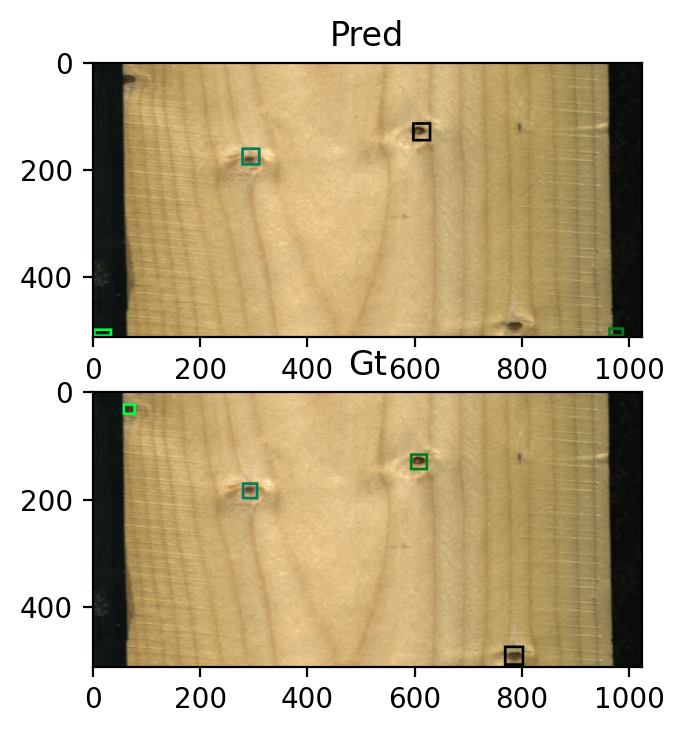

In [ ]:
image = torch.as_tensor(test_data[idx][0], dtype=torch.uint8)
image_draw = draw_bounding_boxes(image, bbox_pred, width=5)
image_draw_gt = draw_bounding_boxes(image, bbox_gt, width=5)
image_draw_pil = to_pil_image(image_draw)
image_draw_pil_gt = to_pil_image(image_draw_gt)
plt.figure(dpi=200)
plt.subplot(211)
plt.imshow(np.asarray(image_draw_pil))
plt.title('Pred')
plt.subplot(212)
plt.imshow(np.asarray(image_draw_pil_gt))
plt.title('Gt')

In [ ]:
cm = box_iou(bbox_gt, bbox_pred)
TP = (cm >= 0.5).sum()
FP = len(bbox_pred) - TP
FN = len(bbox_gt) - TP
acc = TP/(TP+FP+1e-6)
acc

tensor(0.5000)

In [ ]:
label_order = cm.argmax(dim=0)

gt2 = labels_gt[label_order]
cls_cm = np.zeros((8,8))
for i in range(len(gt2)):
  cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

cls_cm

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
box_precisions = []
box_recalls = []
eps = 1e-6
cls_cm = np.zeros((8, 8))

for idx in range(len(test_data)):
  image = test_data[idx][0]
  target = test_data[idx][1]
  rec = model(image.unsqueeze(0).to(device))
  rec = rec[0]

  nms_idx = nms(rec['boxes'], rec['scores'], 0.01)
  bbox_pred = rec['boxes'][nms_idx].cpu()
  labels_pred = rec['labels'][nms_idx].cpu()

  bbox_gt = target['boxes']
  labels_gt = target['labels']

  cm = box_iou(bbox_gt, bbox_pred)
  box_TP = (cm>0.5).sum()
  box_FP = len(bbox_pred) - box_TP
  box_FN = len(bbox_gt) - box_TP

  box_precision = box_TP/(box_TP + box_FP + eps)
  box_recall = box_TP/(box_TP + box_FN + eps)

  box_precisions.append(box_precision)
  box_recalls.append(box_recall)

  gt2 = labels_gt[cm.argmax(dim=0)]
  for i in range(len(gt2)):
    cls_cm[gt2[i]-1, labels_pred[i]-1] += 1

In [ ]:
# with open(os.path.join('Classification_matrix', f'{modelname}_FRCNN.npy'), 'wb') as f:
#   np.save(f, cls_cm)

In [ ]:
cls_precision = np.zeros(8)
cls_recall = np.zeros(8)
for i in range(8):
  cls_precision[i] = cls_cm[i,i]/(cls_cm[:,i].sum()+eps)
  cls_recall[i] = cls_cm[i,i]/(cls_cm[i,:].sum()+eps)
cls_precision

array([0.        , 0.56803797, 0.14285713, 0.        , 0.46691176,
       0.2222222 , 0.03697183, 0.        ])

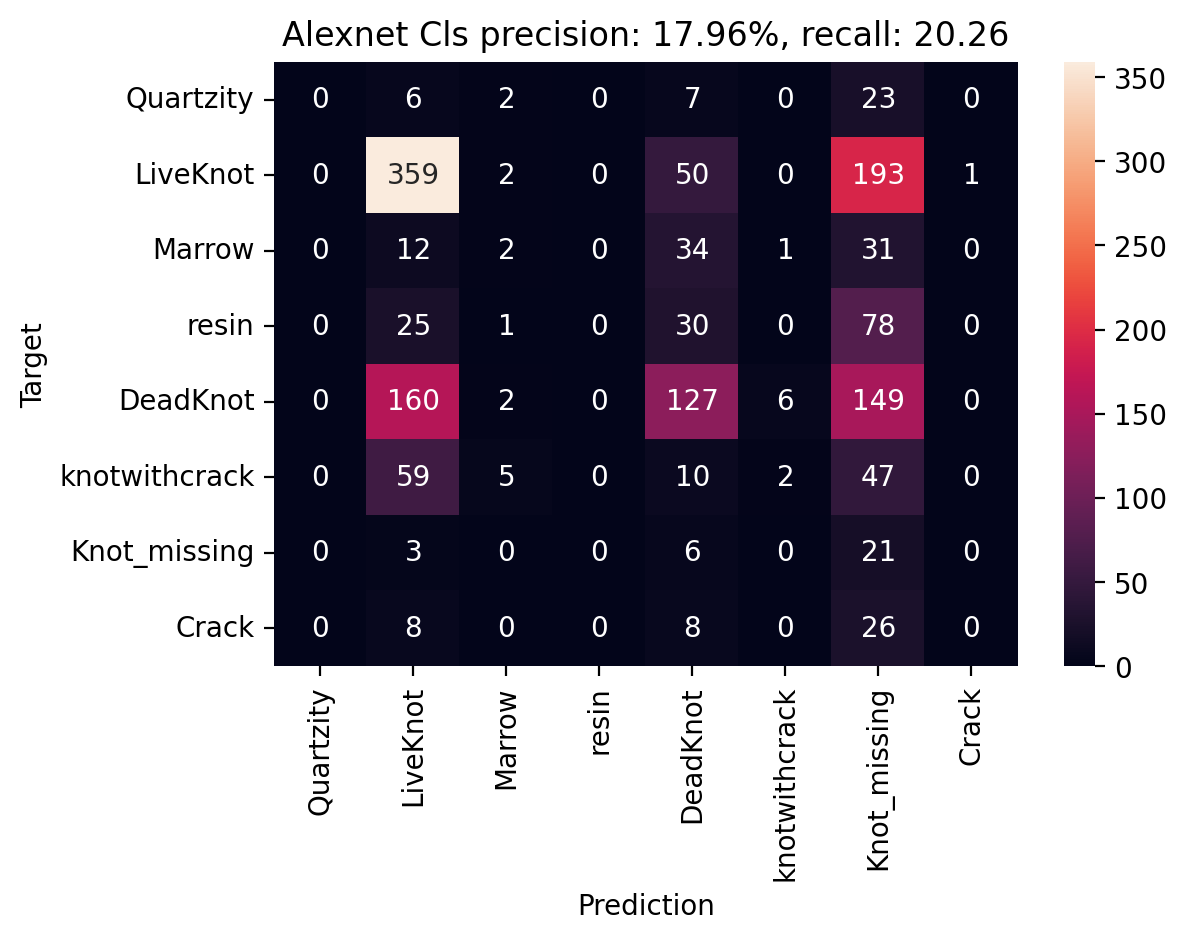

In [ ]:
classes = ['Quartzity', 'LiveKnot', 'Marrow', 'resin', 'DeadKnot', 'knotwithcrack', 'Knot_missing', 'Crack']
df_cls_cm = pd.DataFrame((cls_cm), 
                         index = [i for i in classes], 
                        columns = [i for i in classes], dtype='int')
plt.figure(dpi=200)
sn.heatmap(df_cls_cm, annot=True, fmt='d') 
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title(f'{modelname} Cls precision: {cls_precision.mean()*100:.2f}%, recall: {cls_recall.mean()*100:.2f}')
plt.savefig(os.path.join('Classification_matrix', f'{modelname}_FRCNN.png'))
           

In [ ]:
df = pd.DataFrame(data=[box_precisions, box_recalls], dtype='double').transpose()
df.columns = ['box_precision', 'box_recall']
df.head(10)

,box_precision,box_recall
0,0.000000,0.0
1,0.333333,0.5
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
5,0.500000,0.5
6,0.333333,0.5
7,0.000000,0.0
8,0.000000,0.0
9,0.000000,0.0


In [ ]:
df['box_recall'].mean()

0.2630720114196106